In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 16

In [3]:
df_pca = pd.read_pickle('./pickleJar/df_4_pca3_frombwnorm.pkl')
df_chl = pd.read_pickle('./pickleJar/df_4_AllFeatures_n_Longhurst.pkl')

In [4]:
df_chl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 0 to 494
Data columns (total 23 columns):
datetime         494 non-null datetime64[ns]
lat              494 non-null float64
lon              494 non-null float64
Biome            494 non-null object
BiomCat          494 non-null int64
Province         494 non-null object
ProvCode         494 non-null object
Coastal          494 non-null int64
ProvCat          494 non-null int64
oisst            494 non-null float64
etopo2           494 non-null float64
solz             494 non-null float64
sat_rho_rc412    494 non-null float64
sat_rho_rc443    494 non-null float64
sat_rho_rc490    494 non-null float64
sat_rho_rc510    494 non-null float64
sat_rho_rc555    494 non-null float64
sat_rho_rc670    494 non-null float64
chl_fluo         363 non-null float64
chl_hplc         158 non-null float64
chl              423 non-null float64
log10_chl        423 non-null float64
is_hplc          494 non-null bool
dtypes: bool(1), datetime6

In [5]:
def make_features_from_dt(df, cleanup=True):
    yeardays = max(df.datetime.dt.dayofyear.max(), 365)
    dayminutes = 24 * 60
    doy_arg = 2 * np.pi * df.datetime.dt.dayofyear / yeardays
    mod_arg = 2 * np.pi * (df.datetime.dt.hour * 60 + df.datetime.dt.minute) / dayminutes
    df['sin_doy'] = np.sin(doy_arg)
    df['cos_doy'] = np.cos(doy_arg)
    df['sin_minofday'] = np.sin(mod_arg)
    df['cos_minofday'] = np.cos(mod_arg)
    if cleanup:
        df.drop('datetime', axis=1, inplace=True)
    
    
def make_features_from_latlon(df, cleanup=True):
    df['x'] = np.cos(np.deg2rad(df.lat)) * np.cos(np.deg2rad(df.lon))
    df['y'] = np.cos(np.deg2rad(df.lat)) * np.sin(np.deg2rad(df.lon))
    df['z'] = np.sin(np.deg2rad(df.lat))
    if cleanup:
        df.drop(['lat', 'lon'], axis=1, inplace=True)

def log_transform_feature(df, feature, cleanup=True):
    df['log10_' + feature] = np.log10(df[feature]+1e-6)
    if cleanup:
        df.drop(feature, axis=1, inplace=True)

In [6]:
satcols = df_chl.filter(regex='sat').columns
df_chl.drop(satcols, axis=1, inplace=True)

In [7]:
log_transform_feature(df_chl, 'etopo2')

In [8]:
make_features_from_dt(df_chl)

In [9]:
make_features_from_latlon(df_chl)

In [10]:
df_chl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 0 to 494
Data columns (total 21 columns):
Biome           494 non-null object
BiomCat         494 non-null int64
Province        494 non-null object
ProvCode        494 non-null object
Coastal         494 non-null int64
ProvCat         494 non-null int64
oisst           494 non-null float64
solz            494 non-null float64
chl_fluo        363 non-null float64
chl_hplc        158 non-null float64
chl             423 non-null float64
log10_chl       423 non-null float64
is_hplc         494 non-null bool
log10_etopo2    494 non-null float64
sin_doy         494 non-null float64
cos_doy         494 non-null float64
sin_minofday    494 non-null float64
cos_minofday    494 non-null float64
x               494 non-null float64
y               494 non-null float64
z               494 non-null float64
dtypes: bool(1), float64(14), int64(3), object(3)
memory usage: 81.5+ KB


In [33]:
cols =['sin_doy', 'cos_doy', 'sin_minofday', 'cos_minofday', 'x', 'y', 'z',
       'log10_etopo2', 'oisst', 'solz', 'Biome', 'BiomCat', 'Province', 'ProvCode',
      'Coastal', 'ProvCat']
df_features = df_chl[cols]

In [13]:
df_pca.loc[174]

PC1   NaN
PC2   NaN
PC3   NaN
PC4   NaN
PC5   NaN
PC6   NaN
Name: 174, dtype: float64

In [16]:
df_chl.loc[172:176]

,Biome,BiomCat,Province,ProvCode,Coastal,ProvCat,oisst,solz,chl_fluo,chl_hplc,...,log10_chl,is_hplc,log10_etopo2,sin_doy,cos_doy,sin_minofday,cos_minofday,x,y,z
172,Westerlies,3,N. Pacific Subtropical Gyre Province (West),NPSW,0,47,29.9,20.4,0.12246,NaN,...,-0.912006,False,1.518514,-0.835925,-0.548843,-0.980785,0.195090,0.103633,-0.882449,0.458851
173,Westerlies,3,N. Pacific Subtropical Gyre Province (West),NPSW,0,47,29.9,20.3,0.13777,NaN,...,-0.860845,False,1.602060,-0.835925,-0.548843,-0.923880,0.382683,0.102374,-0.882902,0.458262
175,Westerlies,3,N. Pacific Subtropical Gyre Province (West),NPSW,0,47,29.9,18.1,0.13538,NaN,...,-0.868445,False,1.579784,-0.845249,-0.534373,-0.707107,-0.707107,0.104978,-0.884705,0.454177
176,Westerlies,3,N. Pacific Subtropical Gyre Province (West),NPSW,0,47,29.9,18.2,0.23835,NaN,...,-0.622785,False,1.431364,-0.845249,-0.534373,-0.932008,-0.362438,0.107432,-0.883763,0.455436


In [15]:
df_pca.dropna().loc[172:176]

,PC1,PC2,PC3,PC4,PC5,PC6
172,0.042179,-0.028720,-0.000202,0.003095,0.000890,2.003778e-17
173,0.038200,-0.030585,-0.000523,0.003317,0.000786,3.591620e-17
175,0.038593,-0.030481,-0.001518,0.001891,0.001331,-3.761385e-18
176,0.027936,-0.027678,-0.003713,0.002157,0.001255,3.873667e-17


In [34]:
df_features = pd.merge(df_pca.dropna(), df_features,
                       how='outer', left_index=True, right_index=True)

In [35]:
df_features.loc[172:176].T

,172,173,175,176
PC1,0.0421788,0.0382001,0.0385929,0.0279356
PC2,-0.0287198,-0.0305854,-0.0304809,-0.027678
PC3,-0.000202191,-0.000522719,-0.0015183,-0.00371347
PC4,0.00309476,0.00331656,0.00189053,0.00215677
PC5,0.000889998,0.000786049,0.00133067,0.00125526
PC6,2.00378e-17,3.59162e-17,-3.76138e-18,3.87367e-17
sin_doy,-0.835925,-0.835925,-0.845249,-0.845249
cos_doy,-0.548843,-0.548843,-0.534373,-0.534373
sin_minofday,-0.980785,-0.92388,-0.707107,-0.932008
cos_minofday,0.19509,0.382683,-0.707107,-0.362438


In [36]:
df_ = pd.concat((df_features, df_chl[['log10_chl']]), axis=1)

In [37]:
df_.head().T

,0,1,2,3,4
PC1,0.0259902,0.0605998,0.064018,0.0701748,0.10574
PC2,-0.0247272,-0.0201292,0.0216661,0.0131822,-0.000820722
PC3,-0.00913884,-0.00990766,0.00576502,0.000706246,0.00690341
PC4,0.000774031,-0.00262289,0.00714572,0.00317494,8.47773e-05
PC5,-0.00279683,-0.00346263,0.00157663,-0.00053473,-0.000971181
PC6,1.46499e-17,1.19292e-17,5.57757e-17,3.72957e-17,-6.2726e-17
sin_doy,-0.984474,0.790946,0.758306,0.369725,-0.997917
cos_doy,0.175531,0.611886,0.651899,0.929141,-0.0645084
sin_minofday,0.601815,-0.965926,-0.887011,-0.442289,0.134851
cos_minofday,-0.798636,-0.258819,-0.461749,-0.896873,-0.990866


In [38]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 0 to 494
Data columns (total 23 columns):
PC1             494 non-null float64
PC2             494 non-null float64
PC3             494 non-null float64
PC4             494 non-null float64
PC5             494 non-null float64
PC6             494 non-null float64
sin_doy         494 non-null float64
cos_doy         494 non-null float64
sin_minofday    494 non-null float64
cos_minofday    494 non-null float64
x               494 non-null float64
y               494 non-null float64
z               494 non-null float64
log10_etopo2    494 non-null float64
oisst           494 non-null float64
solz            494 non-null float64
Biome           494 non-null object
BiomCat         494 non-null int64
Province        494 non-null object
ProvCode        494 non-null object
Coastal         494 non-null int64
ProvCat         494 non-null int64
log10_chl       423 non-null float64
dtypes: float64(17), int64(3), object(3)
memory usage

In [39]:
df_.to_pickle('./pickleJar/df_5_AllFeatures_w_Longhurst_n_pca.pkl')

#### Data Standardization

This must happen before computing interactions; i.e. it is not appropriate to standardize interactions. See more [here](http://quantpsy.org/interact/interactions.htm).

In [45]:
x_scaler = StandardScaler()
x_pca_scaler = StandardScaler()

In [42]:
df_.loc[:, :'solz'].head().T

,0,1,2,3,4
PC1,2.599015e-02,6.059977e-02,6.401805e-02,7.017476e-02,1.057401e-01
PC2,-2.472721e-02,-2.012915e-02,2.166605e-02,1.318215e-02,-8.207225e-04
PC3,-9.138836e-03,-9.907661e-03,5.765024e-03,7.062456e-04,6.903413e-03
PC4,7.740306e-04,-2.622886e-03,7.145722e-03,3.174944e-03,8.477726e-05
PC5,-2.796834e-03,-3.462634e-03,1.576635e-03,-5.347301e-04,-9.711815e-04
PC6,1.464986e-17,1.192921e-17,5.577568e-17,3.729566e-17,-6.272597e-17
sin_doy,-9.844738e-01,7.909457e-01,7.583058e-01,3.697245e-01,-9.979172e-01
cos_doy,1.755315e-01,6.118864e-01,6.518990e-01,9.291414e-01,-6.450845e-02
sin_minofday,6.018150e-01,-9.659258e-01,-8.870108e-01,-4.422887e-01,1.348509e-01
cos_minofday,-7.986355e-01,-2.588190e-01,-4.617486e-01,-8.968727e-01,-9.908659e-01


In [52]:
dX = df_.loc[:, :'solz']
dXpca = df_.filter(regex='PC')

In [62]:
dX_s = pd.DataFrame(x_scaler.fit_transform(X), index=df_.index,
                    columns=['%s_s' %col for col in dX.columns])
dXpca_s = pd.DataFrame(x_pca_scaler.fit_transform(Xpca), index=df_.index,
                       columns=['%s_s' % col for col in dXpca.columns])

#### Make Interactions

In [72]:
polymaker = PolynomialFeatures(interaction_only=True, include_bias=False)
Xpoly = polymaker.fit_transform(dX_s.values)
xpoly_col_names = polymaker.get_feature_names(dX_s.columns)
dXpoly = pd.DataFrame(Xpoly, index=df_.index, columns=xpoly_col_names)

In [73]:
pcapolymaker = PolynomialFeatures(interaction_only=True, include_bias=False)
XpolyPca = pcapolymaker.fit_transform(dXpca_s.values)
xpolypca_col_names = pcapolymaker.get_feature_names(dXpca_s.columns)
dXpolyPca = pd.DataFrame(XpolyPca, index=df_.index, columns=xpolypca_col_names)

#### Data Organization

In [65]:
ds = pd.merge(dX_s, df_.loc[:, 'Biome':], how='outer', left_index=True, right_index=True)

In [74]:
dps =  pd.merge(dXpoly, df_.loc[:, 'Biome':], how='outer',
                left_index=True, right_index=True)

In [87]:
dppca = pd.concat((dXpolyPca, dX_s.loc[:, 'sin_doy_s':], df_.loc[:, 'Biome':]),
                  join='outer',axis=1)

In [90]:
dppca.loc[171:176].T

,171,172,173,175,176
PC1_s,0.537491,0.657672,0.595634,0.601758,0.435584
PC2_s,-0.900777,-0.963267,-1.02584,-1.02234,-0.928326
PC3_s,-0.102924,-0.0171452,-0.0443249,-0.128747,-0.314891
PC4_s,0.899953,0.845049,0.905613,0.516223,0.588924
PC5_s,0.419212,0.304966,0.269347,0.455966,0.430128
PC6_s,-1.06364,0.735464,1.19845,0.0415194,1.28069
PC1_s PC2_s,-0.48416,-0.633514,-0.611026,-0.615198,-0.404364
PC1_s PC3_s,-0.0553209,-0.0112759,-0.0264014,-0.0774745,-0.137161
PC1_s PC4_s,0.483717,0.555765,0.539414,0.310641,0.256526
PC1_s PC5_s,0.225323,0.200568,0.160433,0.274381,0.187357


In [91]:
ds.to_pickle('./pickleJar/df_6_FullSet_noInteractions.pkl')
dps.to_pickle('./pickleJar/df_6_FullSet_MaxInteractions.pkl')
dppca.to_pickle('./pickleJar/df_6_FullSet_PCAInteractions.pkl')

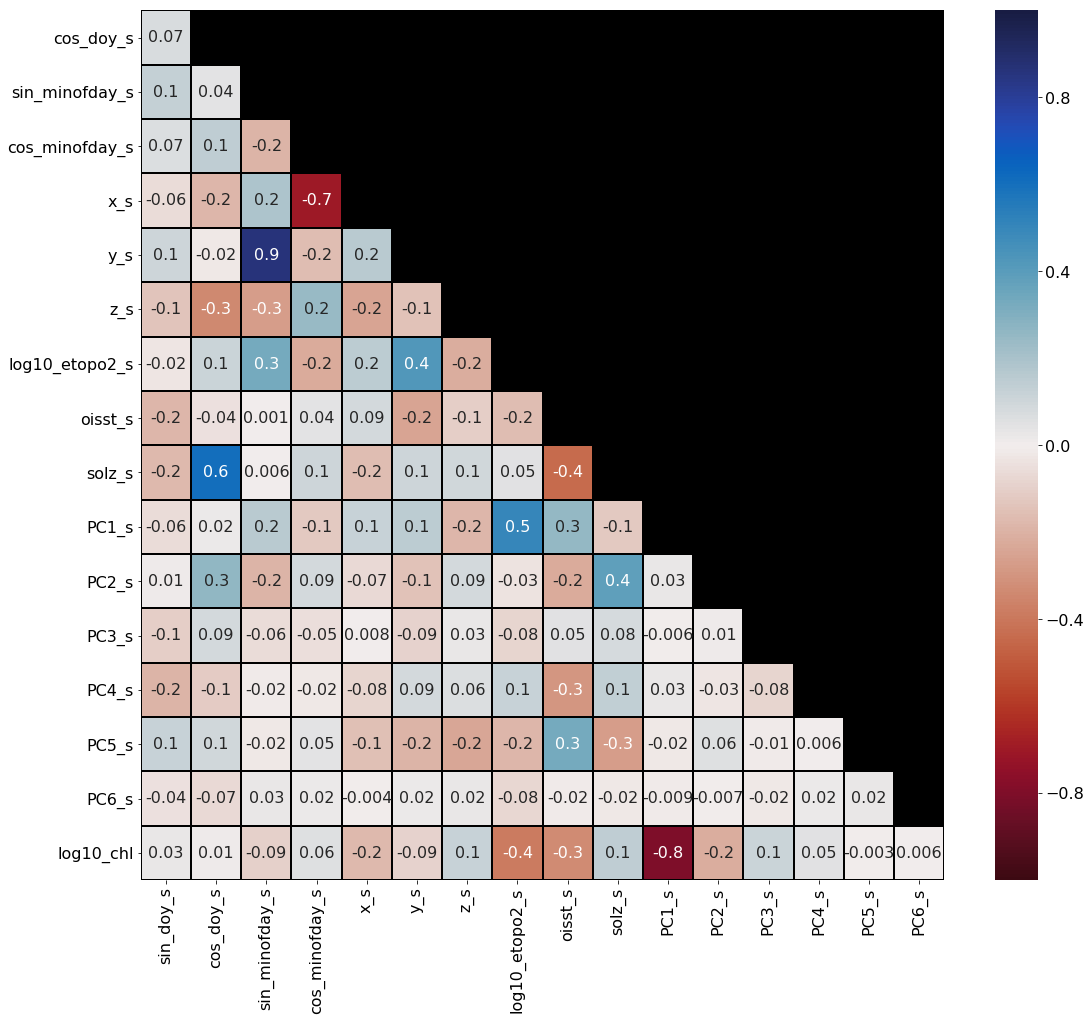

In [120]:
_, ax = pl.subplots(figsize=(18, 16))
ax.set_facecolor('k')
heatmap(d.corr().iloc[1:, :-1], vmin=-1, vmax=1, annot=True, cmap=cmo.balance_r,
       mask=np.triu(np.ones([d.shape[1]-1]*2), k=1), fmt='.1g', linewidth=1,
       linecolor='k');

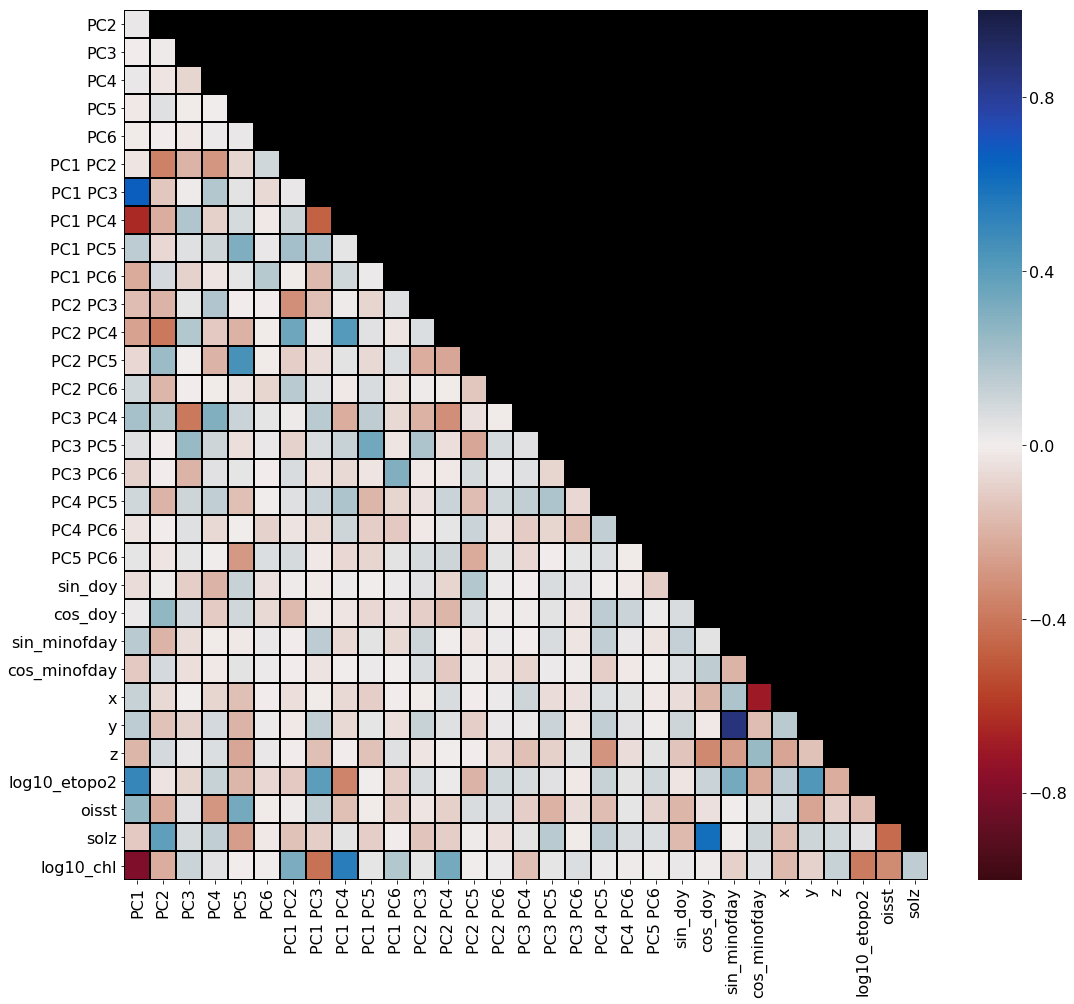

In [201]:
_, ax = pl.subplots(figsize=(18, 16))
ax.set_facecolor('k')
heatmap(dpolypca.corr().iloc[1:, :-1], vmin=-1, vmax=1, cmap=cmo.balance_r,
       mask=np.triu(np.ones([dpolypca.shape[1]-1]*2), k=1), fmt='.1g', linewidth=1,
       linecolor='k');

In [202]:
d.to_pickle('./pickleJar/df_4_AllFeatures_stdized.pkl')

In [203]:
dpoly.to_pickle('./pickleJar/df_4_AllFeaturesPoly_stdized.pkl')

In [204]:
dpolypca.to_pickle('./pickleJar/df_4_AllFeaturesPcaPoly_stdized.pkl')